<a href="https://colab.research.google.com/github/zhongjiawang/AS2/blob/main/Zhongjia_Wang_Assignment_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [61]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):
    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5
    conf_mult=1
    
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates

    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])

    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            ## calculate average treatment effect
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc) 
            ## tauhat = ATE; se_tauhat = standard error of ATE
            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


In [62]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

## Q1 (a) 
### You don't control convariates

$y_i = \tau*T_i+\beta'*x_i+e_i$


Real Life example:
We want to find the effect of eduction to wages. And we also including the years of working experiences. In the fuction above, we assume T is treatment effect of education on wage for individual (yi). X is convarites, in our case is the year of working experiences For question 1(a), we don't control covariates. The treatment effect is directly from education.

𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖 

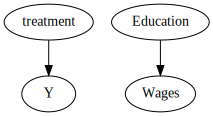

In [63]:
g = gr.Digraph()
g.edge("treatment", "Y")

g.edge("Education", "Wages")

g

In [64]:
#DGP
tau = 4
corr = .5
conf = False
p = 3
p0 = 2 # number of covariates used in the DGP
flagx=1
N=1000
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
data1 = np.concatenate([Y,T,X],axis = 1)
data1 = pd.DataFrame(data1)
data1.columns = ['Y', 'T', 'cov1', 'cov2','cov3']
data1.to_csv('data_cov.csv')
data1

,Y,T,cov1,cov2,cov3
0,-1.416650,0.0,-0.016134,-0.229560,0.266623
1,-1.428179,0.0,-0.607011,0.203483,-1.154814
2,-1.627454,1.0,-0.331442,-0.487843,0.125154
3,-6.552607,0.0,-0.128716,-0.788182,-0.115060
4,5.892215,1.0,0.513018,-0.057073,0.225923
...,...,...,...,...,...
995,-7.404227,1.0,-0.845726,-0.570629,-0.620417
996,2.544536,1.0,-0.169855,0.124609,-0.227522
997,-30.189925,1.0,-2.146663,-2.406931,-2.084859
998,33.074381,1.0,0.439893,3.236354,0.446517


In [65]:
tau = 4
corr = .5
conf = False
p = 5
p0 = 0 # zero covariates used in the DGP
flagx=1
estDict = {}
R = 2000

for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [00:16<00:00, 117.71it/s]

N=100: bias=-0.002373023478224133, RMSE=0.20023138462960563, size=0.053
N=1000: bias=-0.001521430870932713, RMSE=0.06243587751299028, size=0.043


## Q1 (b)
### You control the covariates

$y_i = \tau*T_i+\beta'*x_i+e_i$


In this case, we will add convarites ( years of working experiences)

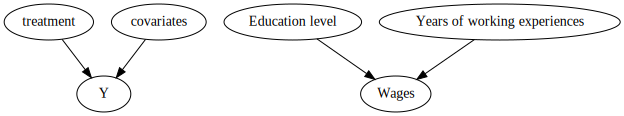

In [66]:
# DAG Illustration
g = gr.Digraph()
g.edge("treatment", "Y")
g.edge("covariates", "Y")

g.edge("Education level", "Wages")
g.edge("Years of working experiences", "Wages")
g

In [67]:
tau = 4
corr = .5
conf = False
p = 3
p0 = 5 # 5 of covariates used in the DGP
flagx=1
estDict = {}
R = 2000

for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [00:16<00:00, 121.18it/s]

N=100: bias=-0.04540464031733691, RMSE=2.9298358880413264, size=0.0545
N=1000: bias=0.05180339359941566, RMSE=0.9515749780287867, size=0.053


# Q2 (a) You fail to control the confounder


Real Life examples: Continue our setting regarding education level effect on wages. The confunder is intellengence. So the intellengence can have both direct effect on education level and wages.

$y_i = \tau*T_i+\beta'*x_i+e_i$

Now,x is a confounder. if fail to control, the regression become:$y_i = \tau*T_i+e_i$

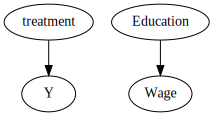

In [68]:
g = gr.Digraph()
g.edge("treatment", "Y")


g.edge("Education", "Wage")


g

DGP

In [69]:

def fn_generate_data_confounder(tau,N,p,corr):
  nvar = p+1 # 1 confounder and variable for randomizing treatment
  corr = 0.5 # correlation for multivariate normal
 
  allX = fn_generate_multnorm(N,corr,nvar)
  C = allX[:,1].reshape([N,1]) # confounder
     
  T = fn_randomize_treatment(N) # choose treated units
  err = np.random.normal(0,1,[N,1])
  Yab = tau*T+0.6*C+err
  Tab = T+0.2*C

  return (Yab,Tab,C)
tau = 3
corr = .5
p = 10
data2 = fn_generate_data_confounder(tau,N,p,corr)
a = pd.DataFrame(data2[0])
b = pd.DataFrame(data2[1])
c = pd.DataFrame(data2[2])
data2 = pd.concat([a,b,c],axis=1)
data2.columns = ['Y','T','Confounder']
data2.to_csv('data_Confounder.csv')

data2

,Y,T,Confounder
0,2.905943,1.038319,0.191594
1,4.463698,1.175570,0.877851
2,0.603163,0.294177,1.470885
3,1.873087,0.756383,-1.218084
4,3.505795,1.049755,0.248777
...,...,...,...
995,-0.160867,-0.068362,-0.341810
996,1.240803,0.969934,-0.150328
997,0.686167,-0.040830,-0.204148
998,-0.601921,0.151312,0.756558


In [70]:
tau = 3
corr = .5
conf = False
p = 10

flagX = 1

estDict = {}
R = 2000

for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [00:35<00:00, 56.74it/s]

N=100: bias=0.0044874031139009885, RMSE=0.15052601358919443, size=0.067
N=1000: bias=-0.001028894353435037, RMSE=0.04533602700583871, size=0.055


## Q2 (b) Control the confounder

$y_i = \tau*T_i+\beta'*x_i+e_i$

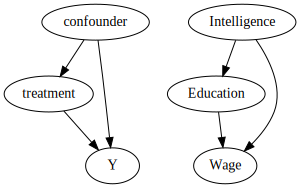

In [71]:
g = gr.Digraph()
g.edge("treatment", "Y")
g.edge("confounder", "Y")
g.edge("confounder","treatment")

g.edge("Education", "Wage")
g.edge("Intelligence", "Wage")
g.edge("Intelligence","Education")

g

In [72]:
tau = 3
corr = .5
conf = True
p = 10

flagX = 1

estDict = {}
R = 2000

for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [00:35<00:00, 56.24it/s]

N=100: bias=-0.0011854029811088288, RMSE=0.15719657148181787, size=0.059
N=1000: bias=-0.0004538577076005967, RMSE=0.04796850727375354, size=0.0495


## Q3 

Real Life Example: We still want to estimate the effect of education level on wages. Now the treatment is education level too. And, we control python coding skill,the more education level can led people to have more pyhthon coding skill and let to high wages. So the python coding skill is mediator.







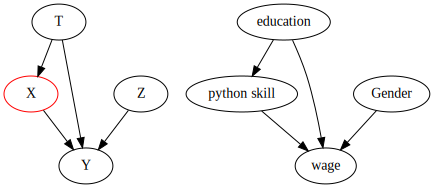

In [73]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("Z", "Y")
g.node("X", "X", color="red")

g.edge("education", "python skill")
g.edge("education", "wage")
g.edge("Gender", "wage")
g.edge("python skill", "wage")

g

$y_i = \tau*T_i+\beta'*x_i+α*Xsel_i+e_i$

In [74]:
def fn_gen_data_selection(tau,N,p,p0,corr,conf = True,flagX = False):

    nvar = p+2 # 1 confounder and variable for randomizing treatment

    if conf==False:
        conf_mult = 0 
    else:
        conf_mult = 1 
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # covariates
    
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    
    u = np.random.normal(0,1,[N,1])
    tmp = random.sample(range(N), round(N*0.4))
    Xsel = np.array([(1 if i in tmp and T[i]==1 else 0) for i in range(N)]).reshape([N,1])
    Xsel = Xsel+36*T+u 
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*100*C+0.01*Xsel+err 
    
    if flagX==False and conf==True:
        return (Yab,T,Xsel,C)
    elif flagX==False and conf==False:
        return (Yab,T,Xsel)
    elif flagX==True and conf==True:
        return (Yab,T,Xsel,C,X[:, :p0])
    else:
        return (Yab,T,Xsel,X[:,:p0])

DGP

In [ ]:
data3 = np.concatenate([Y,T,Xsel],axis = 1)
data3 = pd.DataFrame(data3)
data3.columns = ['Y', 'T', 'Xsel']
data3.to_csv('data_Selection bias.csv')
data3

,Y,T,Xsel
0,-8.815870,1.0,37.176793
1,-5.108761,0.0,-0.973613
2,-21.982790,0.0,-0.559890
3,13.026024,1.0,35.538263
4,-6.341921,1.0,36.751255
...,...,...,...
995,5.626024,1.0,36.396543
996,23.083200,0.0,1.499442
997,-4.845321,0.0,-1.369771
998,-2.507927,0.0,0.421502


###Q3(a). fail to control selection bias

In [75]:
tau = 3  
p = 10   
p0 = 1  
corr = .5 
conf = False  
flagX = 1
R = 2000  

for N in [100, 1000]:
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)):  
        Yexp,T,Xsel,X = fn_gen_data_selection(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,X,const],axis = 1)) 
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [01:01<00:00, 32.33it/s]

N=100: bias=0.36165563139658125, RMSE=0.4149800713080146, size=0.438
N=1000: bias=0.36578759995750565, RMSE=0.3709810773450256, size=1.0


###Q3 (b) control the selection bias


In [76]:
tau = 3 
p = 10   
p0 = 1  
corr = .5 
conf = False  
flagX = 1
R = 2000  

for N in [100, 1000]:
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)):  
        Yexp,T,Xsel,X = fn_gen_data_selection(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,Xsel,X,const],axis = 1))  
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [00:59<00:00, 33.66it/s]

N=1000: bias=-0.027834258916361335, RMSE=1.130083720072551, size=0.055


###Reference
1.Class Jupternote: 1.0 randomize experiment

2.DAG:https://matheusfacure.github.io/python-causality-handbook/04-Graphical-Causal-Models.html

3.Github user: Dinglu Pan

